<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/Consumer_Behavior2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial 

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
def sample_util_params(key):
  subkey1, subkey2 = jax.random.split(key)
  scale = jax.random.uniform(subkey1, minval=1., maxval=10.)
  alpha = jax.random.uniform(subkey2, minval=0.2, maxval=0.8)
  return scale, alpha

def sample_constraint_params(key):
  subkey1, subkey2 = jax.random.split(key)
  m = jax.random.uniform(subkey1, minval=30., maxval=100.)
  p = jax.random.uniform(subkey2, minval=10., maxval=50.)
  return m, p 

In [4]:
def utility_fn(scale, alpha, h, c): 
  return scale *h**alpha * c **(1-alpha)

def budget_constraint(m, p, h):
  return m - p*h

def expenditure_fn(p, h, c):
  return p*h + c

In [5]:
def random_utility(key, h, c): 
  scale, alpha = sample_util_params(key)
  return scale *h**alpha * c **(1-alpha)  

def random_consumption(key, h):
  m, p = sample_constraint_params(key)
  return budget_constraint(m, p, h)

### **Equal Consumption**

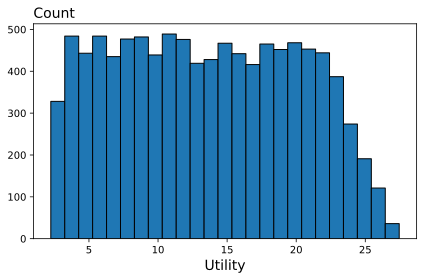

In [6]:
h, c = 2., 3. 
utils = jax.vmap(partial(random_utility, h=h, c=c))(jax.random.split(jax.random.PRNGKey(0), 10000))

fig = plt.figure(dpi=300, tight_layout=True)
plt.hist(utils, edgecolor='black', bins=25)
plt.title('Count', loc='left', size=14)
plt.xlabel('Utility', size=14)
fig.savefig('utils.png', format='png')
plt.show()

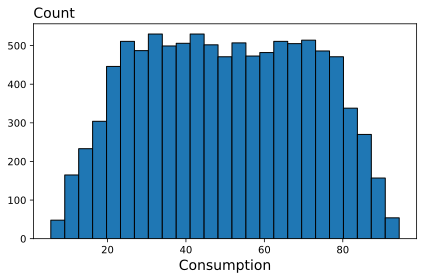

In [7]:
consumption = jax.vmap(partial(random_consumption, h=0.5))(jax.random.split(jax.random.PRNGKey(0), 10000))
fig = plt.figure(dpi=300, tight_layout=True)
plt.hist(consumption, edgecolor='black', bins=25)
plt.title('Count', loc='left', size=14)
plt.xlabel('Consumption', size=14)
fig.savefig('consumption.png', format='png')
plt.show()

In [8]:
def F(utility_fn, expenditure_fn, income, params):
  h, c, l = params
  
  a1, a2 = jax.grad(utility_fn, argnums=(0, 1))(h, c)
  b1, b2 = jax.grad(expenditure_fn, argnums=(0, 1))(h, c)

  return jnp.array([a1 - l*b1, a2-l*b2, income - expenditure_fn(h,c)])

def newton_solver(f_root):

  g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))

  def body_fn(val):
    next_guess = g(val)
    return next_guess #jnp.array(jnp.maximum(next_guess[:-1], jnp.zeros(2)), next_guess[-1])

  def cond_fn(val):
    return jnp.linalg.norm(f_root(val)) > 1e-3

  z = jax.lax.while_loop(cond_fn, body_fn, init_val=jnp.ones(3))
  return z 

In [9]:
def find_optimal_bundle(key):
  subkey1, subkey2 = jax.random.split(key)
  income, price_housing = sample_constraint_params(subkey1)
  scale, alpha = sample_util_params(subkey2)
  partial_utility_fn = partial(utility_fn, scale, alpha)
  partial_expenditure_fn = partial(expenditure_fn, price_housing)

  f_root = partial(F, partial_utility_fn, partial_expenditure_fn, income)
  opt_bundle = newton_solver(f_root)
  h_opt, c_opt = opt_bundle[0], opt_bundle[1]
  return (h_opt, c_opt), (income, price_housing), (scale, alpha)

9.800360282275964
19.016968904788687
38.07662113651748
9.893877509458523
9.135067862335548
46.18487148653976


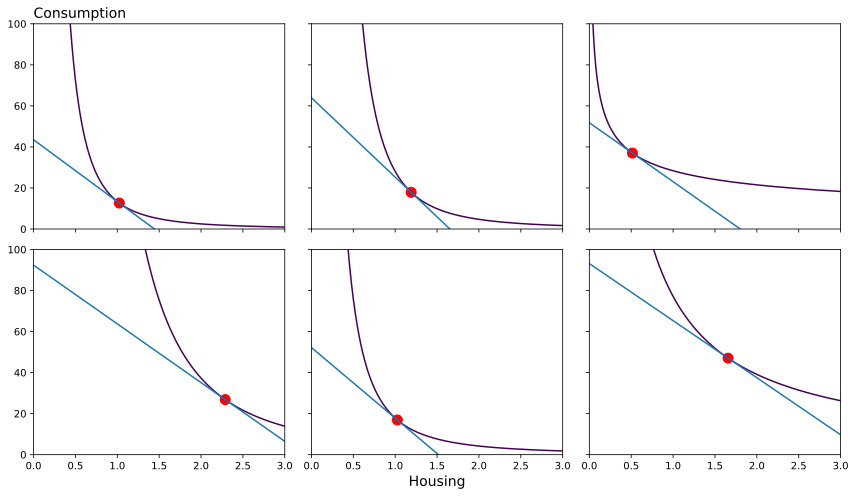

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, dpi=300, tight_layout=True, figsize=(12,7))
for i in range(6):
  row = i//3 
  col = i % 3
  (h_opt, c_opt), (income, price_housing), (scale, alpha) = find_optimal_bundle(jax.random.PRNGKey(i))

  u_opt = utility_fn(scale, alpha, h_opt, c_opt)
  print(u_opt)

  xp=jnp.linspace(0.,3.,200)  # N
  yp=jnp.linspace(0.,100.,200)  # M

  X, Y = jnp.meshgrid(xp, yp)

  def func(x,y):
    return partial(utility_fn, scale, alpha)(x,y)

  Z = func(X,Y)
  ax[row, col].contour(xp,yp,Z,levels=[u_opt.item()]) 
  # plt.title('Consumption', loc='left', size=14)
  # plt.xlabel('Housing', size=14)
  hs = jnp.linspace(0, 3)
  cs = jax.vmap(partial(budget_constraint, income, price_housing))(hs)
  ax[row, col].plot(hs,cs, label='budget line')
  ax[row, col].scatter(h_opt, c_opt, color='red', s=100, label='Optimal Bundle')
  plt.ylim(0, 100.)
  plt.xlim(0, 3.)
  if row==1 and col==1:
    ax[row, col].set_xlabel('Housing', size=14)
  if row==0 and col==0:
    ax[row, col].set_title('Consumption', size=14, loc='left')
fig.savefig('consumer_decisions.png', format='png')
plt.show()

9.800360282275964


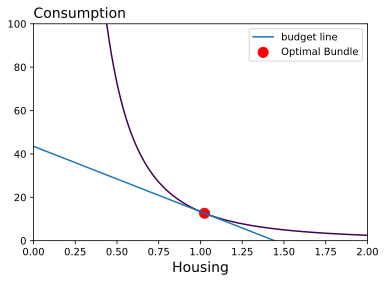

19.016968904788687


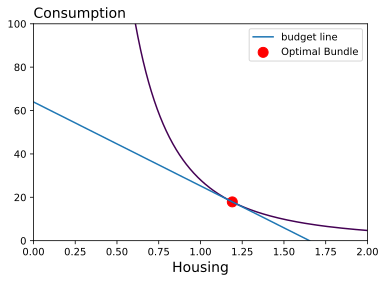

38.07662113651748


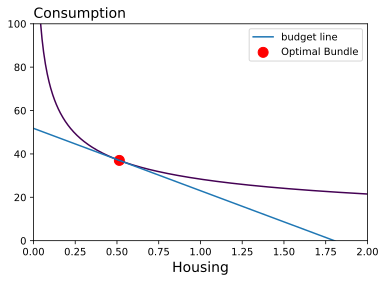

In [31]:
for i in range(3):
  (h_opt, c_opt), (income, price_housing), (scale, alpha) = find_optimal_bundle(jax.random.PRNGKey(i))

  u_opt = utility_fn(scale, alpha, h_opt, c_opt)
  print(u_opt)

  xp=jnp.linspace(0.,2.,200)  # N
  yp=jnp.linspace(0.,100.,200)  # M

  X, Y = jnp.meshgrid(xp, yp)

  def func(x,y):
    return partial(utility_fn, scale, alpha)(x,y)

  Z = func(X,Y)
  plt.contour(xp,yp,Z,levels=[u_opt.item()]) 
  plt.title('Consumption', loc='left', size=14)
  plt.xlabel('Housing', size=14)
  hs = jnp.linspace(0, 2)
  cs = jax.vmap(partial(budget_constraint, income, price_housing))(hs)
  plt.plot(hs,cs, label='budget line')
  plt.scatter(h_opt, c_opt, color='red', s=100, label='Optimal Bundle')
  plt.ylim(0, 100.)
  plt.xlim(0, 2.)
  plt.legend(frameon=True)
  plt.show()